<a href="https://colab.research.google.com/github/duqrldudgns/deep_learning/blob/master/3_5_classifying_newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.4.3'

### 로이터 데이터셋
1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용하겠습니다. 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋입니다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많습니다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있습니다.

IMDB와 MNIST와 마찬가지로 로이터 데이터셋은 케라스에 포함되어 있습니다. 한 번 살펴보죠:

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


In [3]:
len(train_data)


8982

In [4]:
len(test_data)


2246

In [5]:
train_data[10]


[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

궁금한 경우를 위해 어떻게 단어로 디코딩하는지 알아보겠습니다:



In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [7]:
decoded_newswire


'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수입니다.



In [8]:
train_labels[10]


3

### 데이터 준비
이전의 예제와 동일한 코드를 사용해서 데이터를 벡터로 변환합니다:

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸는 방법은 두 가지입니다. 레이블의 리스트를 정수 텐서로 변환하는 것과 원-핫 인코딩을 사용하는 것입니다. 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩이라고도 부릅니다. 원-핫 인코딩에 대한 자세한 설명은 6.1절을 참고하세요. 이 경우 레이블의 원-핫 인코딩은 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터입니다:

In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 훈련 레이블 벡터 변환
one_hot_train_labels = to_one_hot(train_labels)
# 테스트 레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels)

MNIST 예제에서 이미 보았듯이 케라스에는 이를 위한 내장 함수가 있습니다:

In [11]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### 모델 구성
이 토픽 분류 문제는 이전의 영화 리뷰 분류 문제와 비슷해 보입니다. 두 경우 모두 짧은 텍스트를 분류하는 것이죠. 여기에서는 새로운 제약 사항이 추가되었습니다. 출력 클래스의 개수가 2에서 46개로 늘어난 점입니다. 출력 공간의 차원이 훨씬 커졌습니다.

이전에 사용했던 것처럼 Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목이 될 수 있습니다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 것 같습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있습니다.

이런 이유로 좀 더 규모가 큰 층을 사용하겠습니다. 64개의 유닛을 사용해 보죠:

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### 훈련 검증
훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용하겠습니다:

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 57ms/step - loss: 2.4974 - accuracy: 0.4787 - val_loss: 1.6580 - val_accuracy: 0.6570
Epoch 2/20
16/16 [==============================] - 1s 43ms/step - loss: 1.3670 - accuracy: 0.7164 - val_loss: 1.2737 - val_accuracy: 0.7280
Epoch 3/20
16/16 [==============================] - 1s 44ms/step - loss: 1.0376 - accuracy: 0.7793 - val_loss: 1.1387 - val_accuracy: 0.7560
Epoch 4/20
16/16 [==============================] - 1s 43ms/step - loss: 0.8197 - accuracy: 0.8270 - val_loss: 1.0216 - val_accuracy: 0.7800
Epoch 5/20
16/16 [==============================] - 1s 43ms/step - loss: 0.6563 - accuracy: 0.8636 - val_loss: 0.9644 - val_accuracy: 0.8000
Epoch 6/20
16/16 [==============================] - 1s 43ms/step - loss: 0.5265 - accuracy: 0.8885 - val_loss: 0.9254 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 1s 45ms/step - loss: 0.4210 - accuracy: 0.9149 - val_loss: 0.8962 - val_accuracy: 0.8130
Epoch 8/20
16

In [16]:
import matplotlib.pyplot as plt

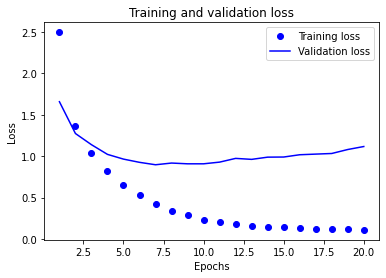

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

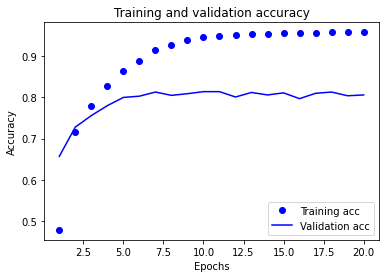

In [21]:
plt.clf()   # 그래프를 초기화합니다

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 52ms/step - loss: 2.5548 - accuracy: 0.4934 - val_loss: 1.6611 - val_accuracy: 0.6250
Epoch 2/9
16/16 [==============================] - 1s 44ms/step - loss: 1.3730 - accuracy: 0.7106 - val_loss: 1.2837 - val_accuracy: 0.7190
Epoch 3/9
16/16 [==============================] - 1s 46ms/step - loss: 1.0226 - accuracy: 0.7828 - val_loss: 1.0838 - val_accuracy: 0.7610
Epoch 4/9
16/16 [==============================] - 1s 43ms/step - loss: 0.8036 - accuracy: 0.8294 - val_loss: 1.0195 - val_accuracy: 0.7750
Epoch 5/9
16/16 [==============================] - 1s 44ms/step - loss: 0.6405 - accuracy: 0.8662 - val_loss: 0.9313 - val_accuracy: 0.8080
Epoch 6/9
16/16 [==============================] - 1s 43ms/step - loss: 0.5117 - accuracy: 0.8925 - val_loss: 0.8971 - val_accuracy: 0.8140
Epoch 7/9
16/16 [==============================] - 1s 43ms/step - loss: 0.4133 - accuracy: 0.9127 - val_loss: 0.8800 - val_accuracy: 0.8120
Epoch 8/9
16/16 [===

In [23]:

results

[0.9778696298599243, 0.7791629433631897]

In [24]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1856634016028495

### 새로운 데이터에 대해 예측하기
모델 인스턴스의 predict 메서드는 46개 토픽에 대한 확률 분포를 반환합니다. 테스트 데이터 전체에 대한 토픽을 예측해 보겠습니다:

In [25]:
predictions = model.predict(x_test)


In [26]:
predictions[0].shape


(46,)

In [27]:
np.sum(predictions[0])


1.0000002

In [28]:
np.argmax(predictions[0])


3


### 레이블과 손실을 다루는 다른 방법
앞서 언급한 것처럼 레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것입니다:

In [29]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])


### 충분히 큰 중간층을 두어야 하는 이유
앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 됩니다. 46차원보다 훨씬 작은 중간층(예를 들면 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.

In [31]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 19ms/step - loss: 2.9888 - accuracy: 0.3567 - val_loss: 2.4603 - val_accuracy: 0.3740
Epoch 2/20
63/63 [==============================] - 1s 18ms/step - loss: 2.1519 - accuracy: 0.3790 - val_loss: 1.9669 - val_accuracy: 0.4160
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 1.6303 - accuracy: 0.5952 - val_loss: 1.5873 - val_accuracy: 0.6120
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.3503 - accuracy: 0.6626 - val_loss: 1.4959 - val_accuracy: 0.6420
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.1920 - accuracy: 0.6916 - val_loss: 1.3935 - val_accuracy: 0.6530
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 1.0609 - accuracy: 0.7091 - val_loss: 1.3568 - val_accuracy: 0.6660
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.9607 - accuracy: 0.7334 - val_loss: 1.3465 - val_accuracy: 0.6830
Epoch 8/20
63